In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from tqdm.notebook import tqdm as tqdm
import faiss
from sentence_transformers import SentenceTransformer, losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

from torch.utils.data import DataLoader

In [4]:
df = pd.read_csv('../data_files/queries.csv.gz', compression='gzip')

In [5]:
# import jsonl file
df = pd.read_json('../data_files/movies.jsonl.gz', lines=True)

In [6]:
df.columns

Index(['id', 'title', 'overview', 'tags', 'genres', 'director', 'actors',
       'characters', 'year', 'votes', 'rating', 'popularity', 'budget', 'url'],
      dtype='object')

In [7]:
from collections import Counter

genres_counts = Counter(g.lower() for genres in df['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 25 genre labels.


Counter({'drama': 3513,
         'comedy': 2601,
         'action': 2526,
         'thriller': 1892,
         'adventure': 1532,
         'horror': 1417,
         'animation': 1406,
         'romance': 1188,
         'crime': 1083,
         'fantasy': 826,
         'children': 720,
         'sci-fi': 633,
         'mystery': 555,
         'family': 318,
         'science fiction': 284,
         'war': 218,
         'documentary': 218,
         'tv movie': 107,
         'western': 94,
         'musical': 92,
         'history': 86,
         'music': 82,
         '(no genres listed)': 50,
         'imax': 26,
         'film-noir': 21})

/var/folders/q9/_hwzlyzd14qc0xyjstc7df380000gn/T/ipykernel_64943/1994186080.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')


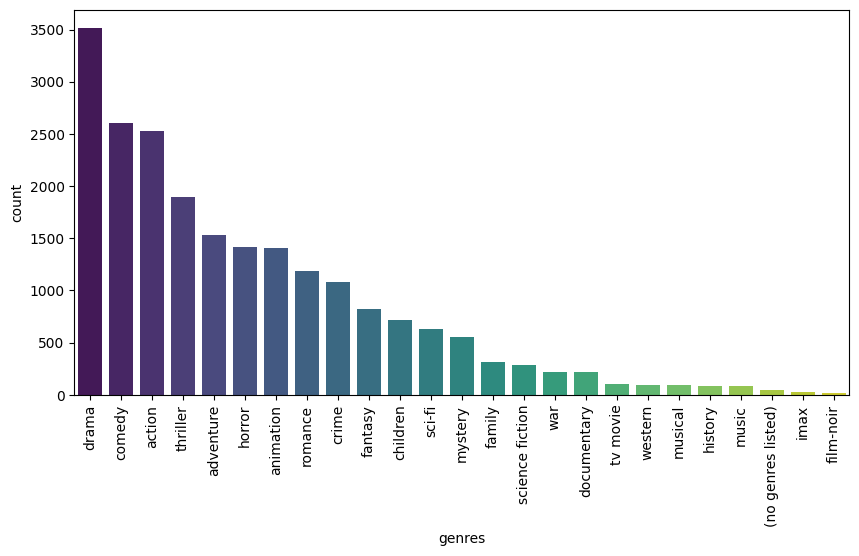

In [8]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

In [9]:
queries = pd.read_csv('../data_files/queries.csv.gz', compression='gzip', sep='\t')

In [10]:
queries['query'].value_counts()

query
insidious 2 netflix     24
borat 1                 24
seventeen again 2000    24
shade of freed          24
interstellar robot      24
                        ..
rapunzel disneyland      6
valhalla steam           6
ghostbusters 4k          6
the deadpool             6
the gravity              6
Name: count, Length: 16279, dtype: int64

In [11]:
queries.label.value_counts() / len(queries)

label
0    0.853816
1    0.146184
Name: count, dtype: float64

#### Printing few examples 

In [12]:
def print_example(idx):
    print(queries.loc[idx, 'query'],"--", df[df['id'] == queries.loc[idx, 'id']]['title'].values[0], "--",queries.loc[idx, 'label'])

for i in range(5):
    print_example(i)

insidious 2 netflix -- The Enforcer -- 0
insidious 2 netflix -- Insidious -- 1
insidious 2 netflix -- Undisputed III: Redemption -- 0
insidious 2 netflix -- Once Upon a Deadpool -- 0
insidious 2 netflix -- 2:22 -- 0


In [12]:
df.head()

,id,title,overview,tags,genres,director,actors,characters,year,votes,rating,popularity,budget,url
0,436270,Black Adam,"Nearly 5,000 years after he was bestowed with ...",[],"[Action, Fantasy, Science Fiction]",Jaume Collet-Serra,"[Sarah Shahi, Dwayne Johnson, Henry Cavill, Pi...","[Adrianna Tomaz, Black Adam / Teth Adam, Clark...",2022,1144,6.863,6202.882,200000000,https://image.tmdb.org/t/p/w154/pFlaoHTZeyNkG8...
1,882598,Smile,"After witnessing a bizarre, traumatic incident...",[],"[Horror, Mystery, Thriller]",Parker Finn,"[Kyle Gallner, Sosie Bacon, Caitlin Stasey, Ka...","[Joel, Dr. Rose Cotter, Laura Weaver, Dr. Morg...",2022,615,6.808,3910.444,17000000,https://image.tmdb.org/t/p/w154/aPqcQwu4VGEewP...
2,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",[],"[Action, Adventure, Science Fiction]",Ryan Coogler,"[Letitia Wright, Angela Bassett, Tenoch Huerta...","[Shuri, Ramonda, Namor, N'Jadaka / Erik 'Killm...",2022,718,7.512,3492.065,250000000,https://image.tmdb.org/t/p/w154/sv1xJUazXeYqAL...
3,966220,Sniper: The White Raven,Mykola is an eccentric pacifist who wants to b...,[],"[Drama, Action, War]",Marian Bushan,"[Maryna Koshkina, Roman Semysal, Andrei Mostre...","[Nastia, Brigade commander, Cap, Mykola]",2022,84,7.423,2403.163,1000000,https://image.tmdb.org/t/p/w154/lZOODJzwuQo0et...
4,663712,Terrifier 2,"After being resurrected by a sinister entity, ...",[],"[Horror, Thriller]",Damien Leone,"[Lauren LaVera, David Howard Thornton, Katie M...","[Sienna, Art the Clown, Monica Brown, Victoria...",2022,612,7.000,2015.172,250000,https://image.tmdb.org/t/p/w154/b6IRp6Pl2Fsq37...


In [28]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

def preprocess(text):
    doc = nlp(str(text).lower())
    preprocessed_text = []
    for token in doc:
        if token.is_punct or token in stop_words or token.is_space:
            continue
        preprocessed_text.append(token.lemma_.lower().strip())
    return ' '.join(preprocessed_text)

# Apply preprocessing to relevant columns
for col in tqdm(['title', 'overview', 'genres', 'director', 'actors']):
    df[f'{col}_preprocessed'] = df[col].apply(preprocess)


  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
df.head()

,id,title,overview,tags,genres,director,actors,characters,year,votes,rating,popularity,budget,url,title_preprocessed,overview_preprocessed,genres_preprocessed,director_preprocessed,actors_preprocessed
0,436270,Black Adam,"Nearly 5,000 years after he was bestowed with ...",[],"[Action, Fantasy, Science Fiction]",Jaume Collet-Serra,"[Sarah Shahi, Dwayne Johnson, Henry Cavill, Pi...","[Adrianna Tomaz, Black Adam / Teth Adam, Clark...",2022,1144,6.863,6202.882,200000000,https://image.tmdb.org/t/p/w154/pFlaoHTZeyNkG8...,black adam,"nearly 5,000 year after he be bestow with the ...",action fantasy science fiction,jaume collet serra,sarah shahi dwayne johnson henry cavill pierce...
1,882598,Smile,"After witnessing a bizarre, traumatic incident...",[],"[Horror, Mystery, Thriller]",Parker Finn,"[Kyle Gallner, Sosie Bacon, Caitlin Stasey, Ka...","[Joel, Dr. Rose Cotter, Laura Weaver, Dr. Morg...",2022,615,6.808,3910.444,17000000,https://image.tmdb.org/t/p/w154/aPqcQwu4VGEewP...,smile,after witness a bizarre traumatic incident inv...,horror mystery thriller,parker finn,kyle gallner sosie bacon caitlin stasey kal pe...
2,505642,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",[],"[Action, Adventure, Science Fiction]",Ryan Coogler,"[Letitia Wright, Angela Bassett, Tenoch Huerta...","[Shuri, Ramonda, Namor, N'Jadaka / Erik 'Killm...",2022,718,7.512,3492.065,250000000,https://image.tmdb.org/t/p/w154/sv1xJUazXeYqAL...,black panther wakanda forever,queen ramonda shuri m’baku okoye and the dora ...,action adventure science fiction,ryan coogler,letitia wright angela bassett tenoch huerta mi...
3,966220,Sniper: The White Raven,Mykola is an eccentric pacifist who wants to b...,[],"[Drama, Action, War]",Marian Bushan,"[Maryna Koshkina, Roman Semysal, Andrei Mostre...","[Nastia, Brigade commander, Cap, Mykola]",2022,84,7.423,2403.163,1000000,https://image.tmdb.org/t/p/w154/lZOODJzwuQo0et...,sniper the white raven,mykola be an eccentric pacifist who want to be...,drama action war,marian bushan,maryna koshkina roman semysal andrei mostrenko...
4,663712,Terrifier 2,"After being resurrected by a sinister entity, ...",[],"[Horror, Thriller]",Damien Leone,"[Lauren LaVera, David Howard Thornton, Katie M...","[Sienna, Art the Clown, Monica Brown, Victoria...",2022,612,7.000,2015.172,250000,https://image.tmdb.org/t/p/w154/b6IRp6Pl2Fsq37...,terrifi 2,after be resurrect by a sinister entity art th...,horror thriller,damien leone,lauren lavera david howard thornton katie magu...


In [30]:
# Initialize the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each movie
embeddings = []
for idx, row in tqdm(df.iterrows()):
    df = df.copy()
    combined_text = ' '.join([row[f'{col}_preprocessed'] for col in ['title', 'overview', 'genres', 'director', 'actors']])
    df.loc[idx, 'combined_text'] = combined_text
    embedding = model.encode(combined_text)
    embeddings.append(embedding)
    combined_text = ""

# Convert list of embeddings to a NumPy array
embeddings_array = np.vstack(embeddings)


/Users/shreemit/miniforge3/envs/gemini/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0it [00:00, ?it/s]

In [43]:
df.to_csv('../data_files/movies_preprocessed.csv', index=False)

In [16]:
queries['query_preprocessed'] = queries['query'].apply(preprocess)
queries

,query,platform,columns,id,bm25,user,timestamp,label,query_preprocessed
0,insidious 2 netflix,desktop,3,846433,4.340183,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix
1,insidious 2 netflix,desktop,3,49018,5.832387,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,1,insidious 2 netflix
2,insidious 2 netflix,desktop,3,38234,3.484961,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix
3,insidious 2 netflix,desktop,3,567604,4.334854,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix
4,insidious 2 netflix,desktop,3,269795,4.811110,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix
...,...,...,...,...,...,...,...,...,...
384750,2013 the wolverine,desktop,1,263115,5.931900,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine
384751,2013 the wolverine,desktop,1,25913,2.498212,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine
384752,2013 the wolverine,desktop,1,567604,2.592783,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine
384753,2013 the wolverine,desktop,1,533535,3.620786,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine


In [17]:
combined_df = queries.merge(df, left_on='id', right_on='id', how='inner')
combined_df

,query,platform,columns,id,bm25,user,timestamp,label,query_preprocessed,title,...,popularity,budget,url,title_preprocessed,overview_preprocessed,genres_preprocessed,director_preprocessed,actors_preprocessed,characters_preprocessed,combined_text
0,insidious 2 netflix,desktop,3,846433,4.340183,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix,The Enforcer,...,13.628,0,https://image.tmdb.org/t/p/w154/pXC8JJbfnRWtbD...,the enforcer,a noir thriller set in miami the film follow a...,action thriller drama,richard hughes,antonio bandera kate bosworth natalie burn moj...,cuda estelle olivia stray billie joe lexus fre...,the enforcer a noir thriller set in miami the ...
1,insidious 2 netflix,desktop,3,49018,5.832387,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,1,insidious 2 netflix,Insidious,...,64.003,1500000,https://image.tmdb.org/t/p/w154/tmlDFIUpGRKiuW...,insidious,a family discover that dark spirit have invade...,fantasy horror thriller,james wan,patrick wilson rise byrne ty simpkin lin shaye...,josh lambert renai lambert dalton lambert elis...,insidious a family discover that dark spirit h...
2,insidious 2 netflix,desktop,3,38234,3.484961,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix,Undisputed III: Redemption,...,143.211,3000000,https://image.tmdb.org/t/p/w154/g8KB77SPA7SyU8...,undisputed iii redemption,russian inmate boyka now severely hobble by th...,action crime drama,isaac florentine,scott adkin robert costanzo velislav pavlov la...,yuri boyka farnatti chief guard santiago silva...,undisputed iii redemption russian inmate boyka...
3,insidious 2 netflix,desktop,3,567604,4.334854,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix,Once Upon a Deadpool,...,32.913,0,https://image.tmdb.org/t/p/w154/5Ka49BWWyKMXr9...,once upon a deadpool,a kidnap fred savage be force to endure deadpo...,action comedy,david leitch,ryan reynolds bill skarsgård evan peters brad ...,wade wilson deadpool juggernaut voice zeitgeis...,once upon a deadpool a kidnap fred savage be f...
4,insidious 2 netflix,desktop,3,269795,4.811110,455a1c6ec9b0d1126d0d056d66eac175,1669314612784,0,insidious 2 netflix,2:22,...,21.058,0,https://image.tmdb.org/t/p/w154/rj0h3RnKX5CB8X...,2:22,a man 's life be derail when an ominous patter...,drama thriller,paul currie,teresa palmer sam reid michiel huisman maeve d...,sarah jona dylan branson sandy bill serena tic...,2:22 a man 's life be derail when an ominous p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384750,2013 the wolverine,desktop,1,263115,5.931900,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine,Logan,...,68.287,97000000,https://image.tmdb.org/t/p/w154/fnbjcRDYn6YviC...,logan,in the near future a weary logan care for an a...,action sci fi,james mangold,hugh jackman patrick stewart boyd holbrook ste...,logan wolverine x-24 charles xavier professor ...,logan in the near future a weary logan care fo...
384751,2013 the wolverine,desktop,1,25913,2.498212,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine,Balto II: Wolf Quest,...,21.026,0,https://image.tmdb.org/t/p/w154/dZ958HnW3JO2pE...,balto ii wolf quest,balto and his daughter aleu embark on a journe...,family animation adventure,phil weinstein,mark hamill lacey chabert peter macnicol david...,niju the evil wolf voice aleu voice muru voice...,balto ii wolf quest balto and his daughter ale...
384752,2013 the wolverine,desktop,1,567604,2.592783,36a2d31e52182b4d78bfcb8e38105d05,1669410650410,0,2013 the wolverine,Once Upon a Deadpool,...,32.913,0,https://image.tmdb.org/t/p/w154/5Ka49BWWyKMXr9...,once upon a deadpool,a kidnap fred savage be force to endure deadpo...,action comedy,david leitch,ryan reynolds bill skarsgård evan peters brad ...,wade wilson deadpool juggernaut voice zeitgeis...,once upon a deadpool a kidnap fred savage be f...
384753,2013 the wolverine,desktop,1,533535,3.620786,36a2d31e52182b4d78bfcb8e38105d05,166941065041

In [13]:
# combined_df.to_csv('../data_files/combined_df.csv', index=False)
combined_df = pd.read_csv('../data_files/combined_df.csv')

In [31]:
# Create a FAISS index
dimension = embeddings_array.shape[1]
index = faiss.IndexFlatL2(dimension)

# Add embeddings to the index
index.add(embeddings_array)


In [40]:
faiss.write_index(index, '../faiss_index')


In [41]:
# Example query
query = "movie where one kid working at mit is a genius mathematician and solves a complex math problem matt damon is the lead actor"
# query = "good action movies with war in vietnam tom hanks"
# query = "insidious 2 chapter 2"
preprocessed_query = preprocess(query)
query_embedding = model.encode(preprocessed_query)

# Search the FAISS index
k = 8 # Number of nearest neighbors to retrieve
distances, indices = index.search(np.array(query_embedding).reshape(1, -1), k)

# Retrieve movie details based on the indices
results = df.iloc[indices[0]]
results[['title', 'director', 'actors', 'genres', 'overview']]


,title,director,actors,genres,overview
7629,Pi,Darren Aronofsky,"[Mark Margolis, Ben Shenkman, Samia Shoaib, Aj...","[drama, sci-fi, thriller]",A mathematical genius discovers a link between...
215,Interstellar,Christopher Nolan,"[William Devane, Timothée Chalamet, Matt Damon...","[sci-fi, imax]",The adventures of a group of explorers who mak...
1951,Good Will Hunting,Gus Van Sant,"[Cole Hauser, Matt Damon, Stellan Skarsgård, B...","[drama, romance]",Will Hunting has a genius-level IQ but chooses...
7860,Jimmy Neutron: Boy Genius,John A. Davis,"[Patrick Stewart, Frank Welker, Martin Short, ...","[adventure, animation, children]",Jimmy Neutron is a boy genius and way ahead of...
6258,UFO,Ryan Eslinger,"[Ella Purnell, Gillian Anderson, David Stratha...",[mystery],"A college student, who sees a UFO, uses his ex..."
6079,Stand and Deliver,Ramón Menéndez,"[Andy García, Lou Diamond Phillips, Edward Jam...","[comedy, drama]",Jaime Escalante is a mathematics teacher in a ...
3185,X+Y,Morgan Matthews,"[Rafe Spall, Eddie Marsan, Sally Hawkins, Alex...","[comedy, drama]",A socially awkward teenage math prodigy finds ...
2957,21,Robert Luketic,"[Laurence Fishburne, Kate Bosworth, Josh Gad, ...","[crime, drama, romance]","Ben Campbell is a young, highly intelligent, s..."


In [22]:
train_examples = []
test_examples = []

train_queries, test_queries = train_test_split(combined_df, test_size=0.2, random_state=42)

for idx, row in tqdm(train_queries.iterrows()):
    if row['label'] == 1:
        train_examples.append(InputExample(texts=[row['query_preprocessed'], row['title_preprocessed']], label=row['label']))

for idx, row in tqdm(test_queries.iterrows()):
    if row['label'] == 1:
        test_examples.append(InputExample(texts=[row['query_preprocessed'], row['title_preprocessed']], label=row['label']))


train_examples[:5]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [23]:
model = SentenceTransformer('all-MiniLM-L6-v2')


train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

/Users/shreemit/miniforge3/envs/gemini/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=1, 
          warmup_steps=100, 
          evaluator=EmbeddingSimilarityEvaluator.from_input_examples(test_examples, name='movie-recommender'),
          show_progress_bar=True,
          output_path='../train_models/sebert-movie-search')

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2808 [00:00<?, ?it/s]

: 

In [14]:
# loading the trained model
model = SentenceTransformer('../trained_models/finetuned_senBERT_testset_v4')

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
# Encode the documents using the model
document_embeddings = model.encode(df['title'])
def semantic_search(query, movie_titles, top_k=3):
    """
    Perform semantic search for a given query.
    """
    # Encode the query using the model
    query_embedding = model.encode([query])

    # Compute the cosine similarities between the query and each document
    similarities = cosine_similarity(query_embedding, document_embeddings)[0]

    # Rank the document indices by similarity
    ranked_doc_indices = np.argsort(similarities)[::-1][:top_k]

    # Return the top_k most similar documents
    return [movie_titles[idx] for idx in ranked_doc_indices]

In [22]:
# semantic_search("incidious 2", df['title'])
semantic_search("hangover", df['title'])

['The Hangover', 'The Hangover Part II', 'The Hangover Part III']